In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import fun.net as net 

print(tf.config.list_physical_devices('GPU'))  # Confirm GPU availability 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# According to https://blog.csdn.net/hxj0323/article/details/121629067
# Implement GPU memory allocation according to demand
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0 :
    for gpu in gpu_list:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("Got no GPUs")

In [8]:
# load data
x_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy', )

x_test = np.load('data/x_test.npy', )
y_test = np.load('data/y_test.npy', )

x_val = np.load('data/x_val.npy', )
y_val_label = np.load('data/y_val.npy', )

In [9]:
# Neural network parameters

name_base = 'state4'
space_name = 'PPWP'

Hs = 1.88

batch_size = 256
learning_rate = 0.0001

TIME_END = 120 
EARLY_STOPPING = 300
patience = 0.0001  # patience in early stopping

# dt = 0.4, so t_a = inputs_shape * dt = 160 s and t_b = output_shape * dt  
inputs_shape = 400
output_shape = 750 

act_f_list = ['elu', 'relu']

space = [act_f_list]

w_init = tf.keras.initializers.GlorotUniform

time_now = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())).replace(' ', '-').replace(':', '-')


model name: state4-sn-0-actf-elu-2024-03-02-16-45-51
0
0.027727085094039258
0.02777437
365


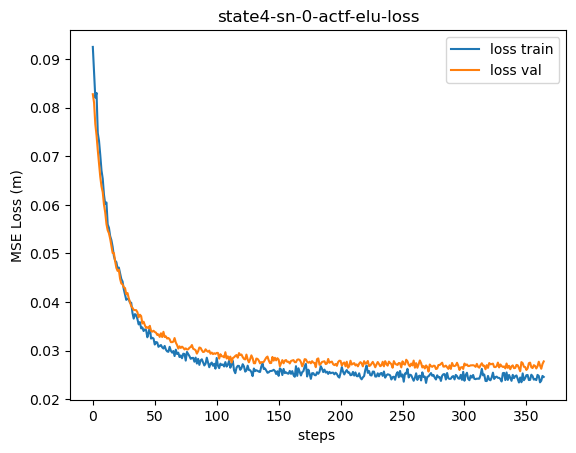

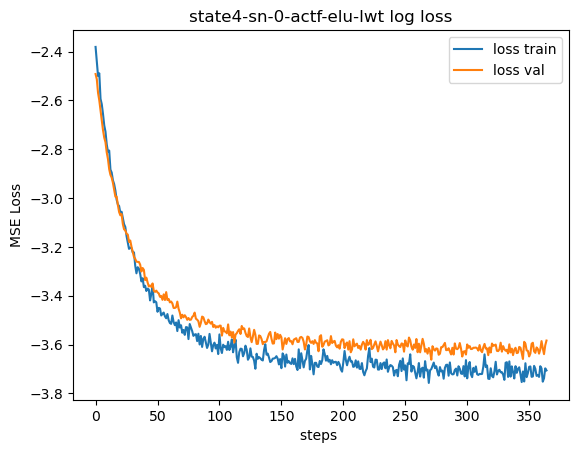

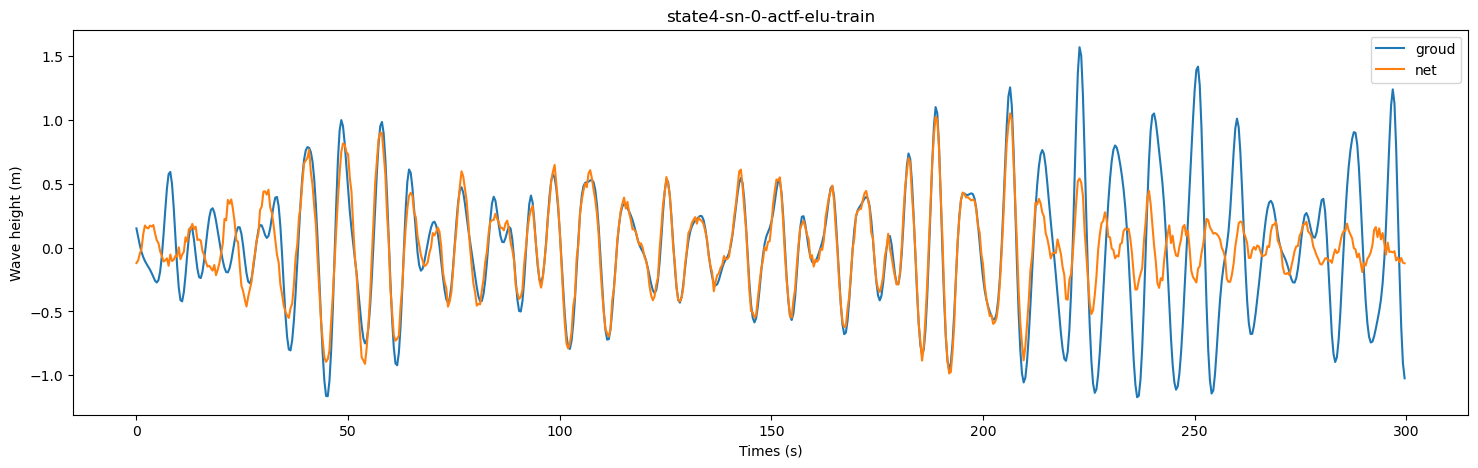

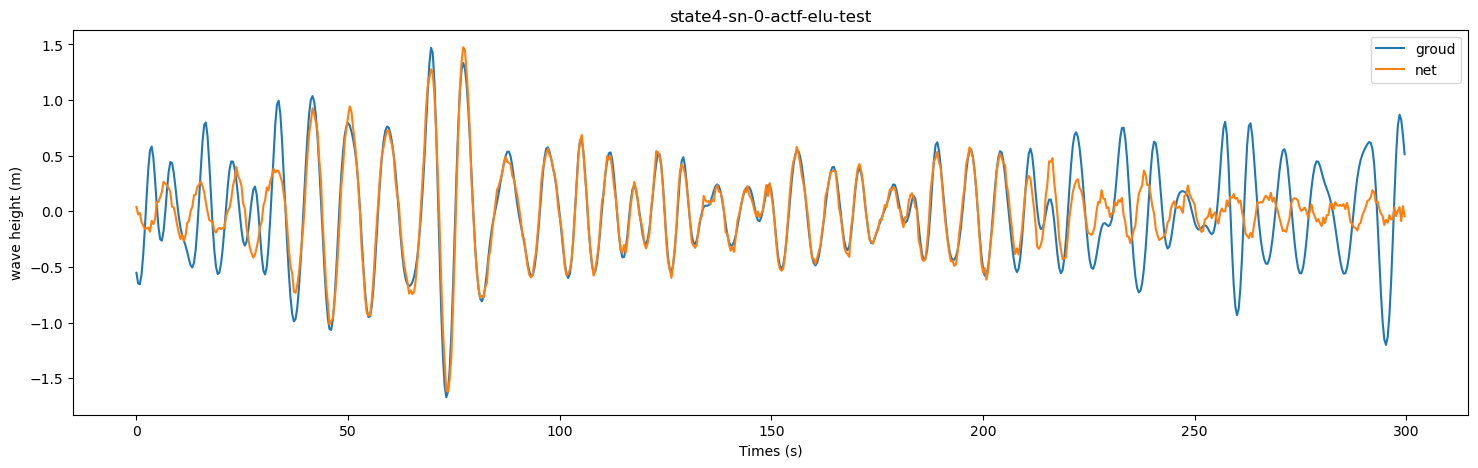

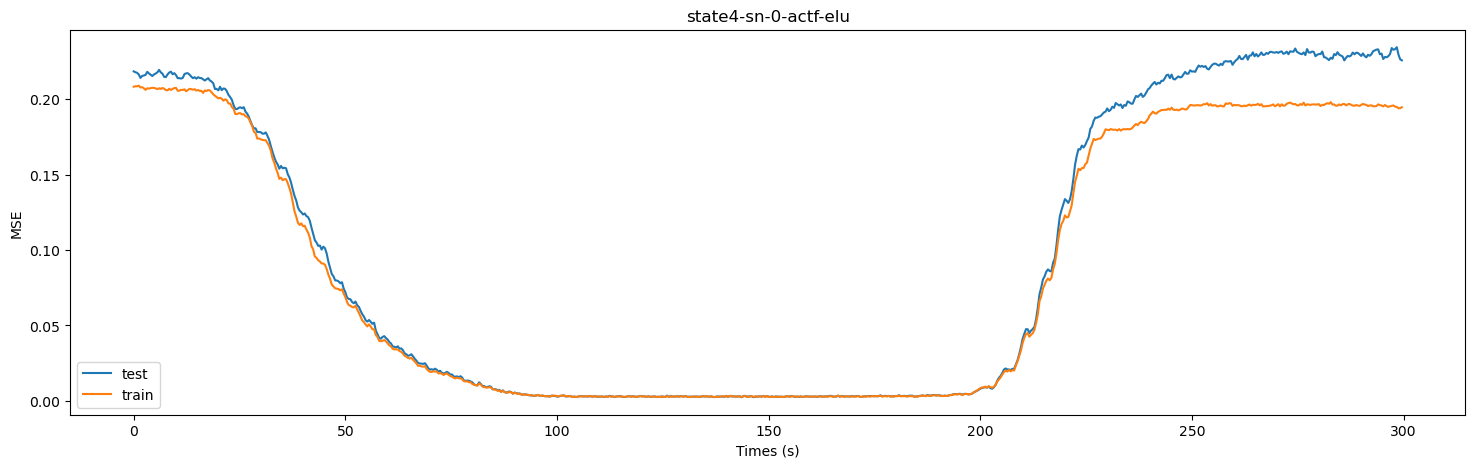

model name: state4-sn-1-actf-relu-2024-03-02-16-45-51
1
0.030177121359020172
0.030197538
457


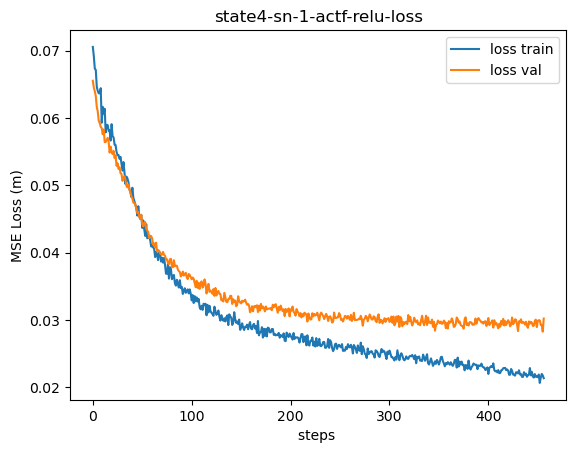

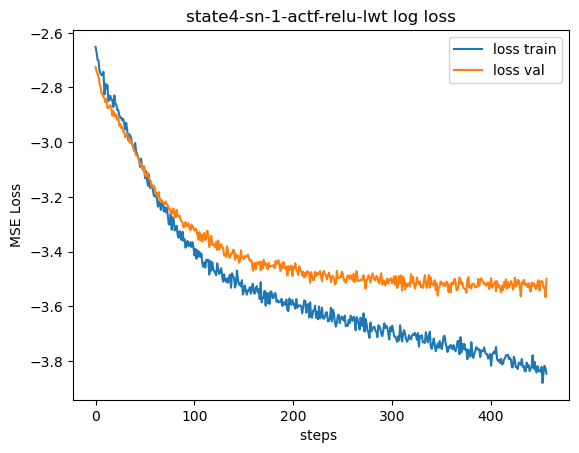

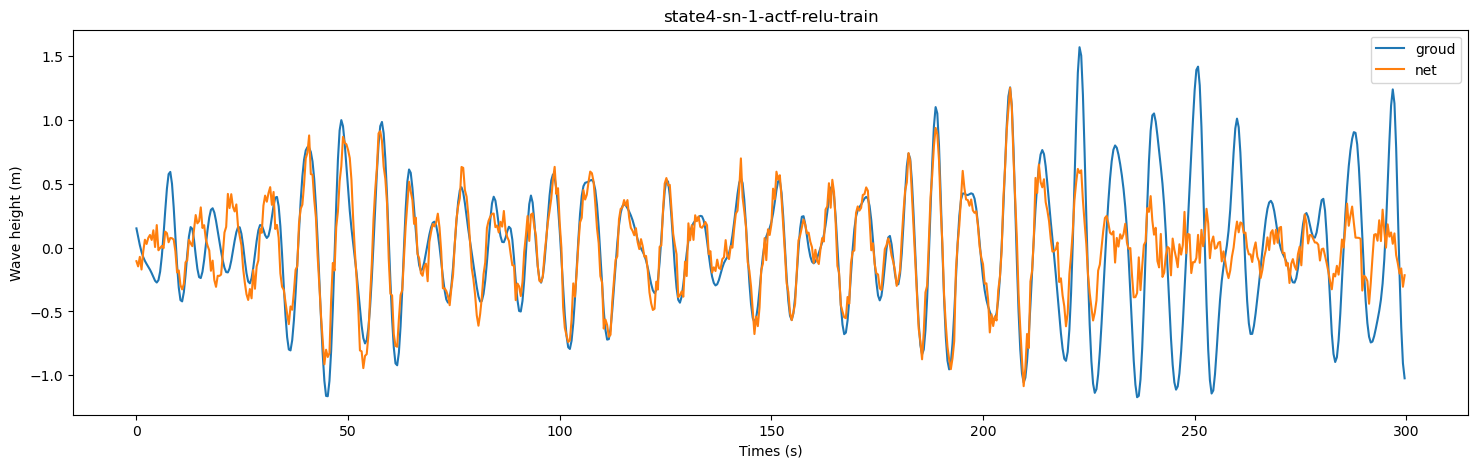

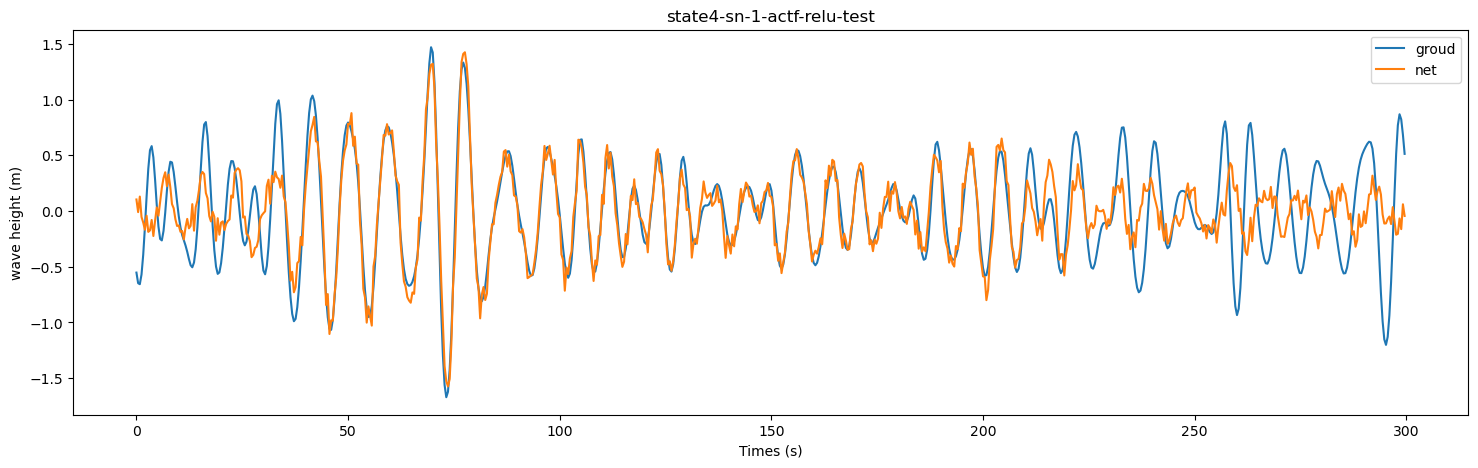

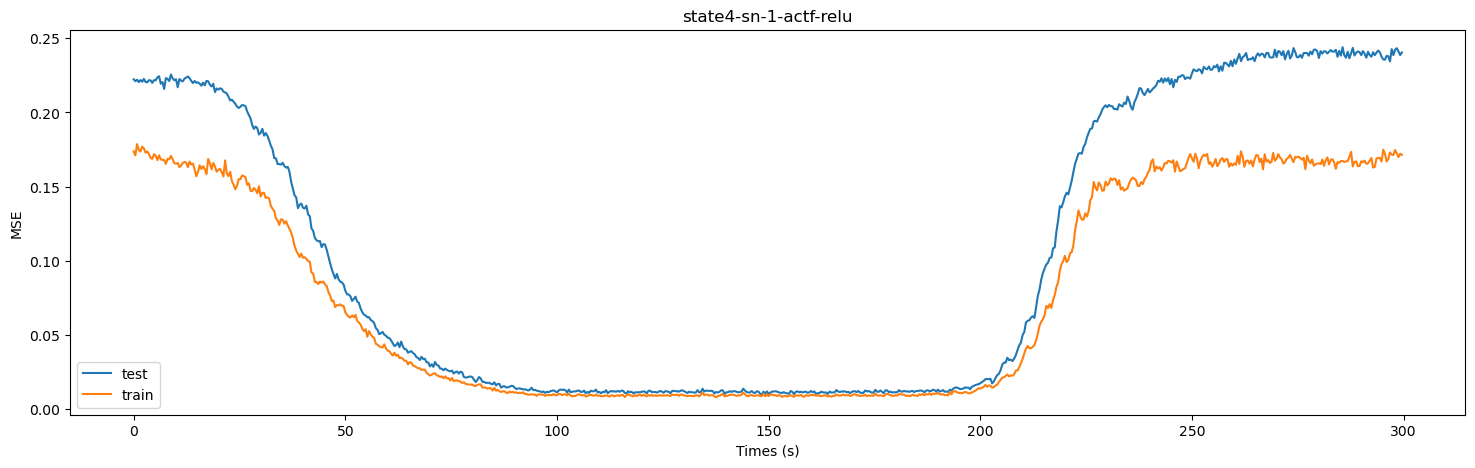

In [10]:
for sn, act_f in enumerate(act_f_list):
    name =  name_base +'-sn-' + str(sn) +  '-actf-' + act_f  
    MODEL_NAME = name  + '-' + time_now

    print("model name:", MODEL_NAME, )
    SAVE_PATH =  './models/' + space_name + '/'+ MODEL_NAME
    
    mlp = net.Mlp([inputs_shape, int(3*inputs_shape),int(3*inputs_shape),  output_shape], act_fun=act_f, w_init=w_init)
    ckpt = tf.train.Checkpoint(step=tf.Variable(0), net=mlp)
    manager = tf.train.CheckpointManager(ckpt, SAVE_PATH, max_to_keep=3)
    op_adam = tf.keras.optimizers.Adam(learning_rate)
    
    # set tensorboard 
    TRAIN_LOG_DIR = './logs/' + space_name + '/'+ MODEL_NAME + '/train'
    VAL_LOG_DIR = './logs/' + space_name + '/'+ MODEL_NAME + '/val'
    train_summary_writer = tf.summary.create_file_writer(TRAIN_LOG_DIR)
    val_summary_writer = tf.summary.create_file_writer(VAL_LOG_DIR)

    time_end  = TIME_END
    i = 0 
    
    time_start = time.time()
    loss_train_list = []
    loss_val_list = []

    while time.time() - time_start < time_end:

            with tf.GradientTape(persistent=True) as tape:

                index = np.random.randint(low=0, high=x_train.shape[0], size=batch_size)
                index = np.unique(index)

                y = mlp(x_train[index, :])

                loss = tf.reduce_mean(tf.square(y_train[index, :] - y))
                e_gradients = tape.gradient(loss, mlp.trainable_variables)
                op_adam.apply_gradients(zip(e_gradients, mlp.trainable_variables))

            del tape
            loss_train_list.append(loss.numpy())

            index_val = np.random.randint(low=0, high=x_val.shape[0], size=batch_size)
            index_val = np.unique(index_val)  
            y_valid = mlp(x_val[index_val, :])

            loss_valid = tf.reduce_mean(tf.square(y_valid - y_val_label[index_val, :])) 
            loss_val_list.append(loss_valid.numpy())
            
            # early stopping part 
            if patience + len(loss_val_list)>300 and sum(loss_val_list[-EARLY_STOPPING:-1])/len(loss_val_list[-EARLY_STOPPING:-1]) < loss_valid.numpy():
                print(sn)
                print(sum(loss_val_list[-EARLY_STOPPING:-1])/len(loss_val_list[-EARLY_STOPPING:-1]))
                print(loss_valid.numpy())
                print(len(loss_val_list))
                time_end = 0 

            # save loss
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=i)
     
            with val_summary_writer.as_default():
                tf.summary.scalar('loss', loss_valid, step=i)
            # add epochs             
            i = i + 1 
    #         """"""
    # save mlp 
    # save_path = manager.save()

    # show loss 
    xticks = np.arange(len(loss_train_list))
    plt.plot(xticks, loss_train_list)
    plt.plot(xticks, loss_val_list)
    plt.xlabel('steps ')
    plt.ylabel('MSE Loss (m)')
    plt.title(name + '-loss')
    plt.legend(['loss train', 'loss val'])
    plt.show()

    # show log loss 
    xticks = np.arange(len(loss_train_list))
    plt.plot(xticks, np.log(loss_train_list))
    plt.plot(xticks, np.log(loss_val_list))
    plt.xlabel('steps ')
    plt.ylabel('MSE Loss')
    plt.title(name + '-lwt log loss')
    plt.legend(['loss train', 'loss val'])
    plt.show()


    y = mlp(x_train)
    t = np.arange(output_shape)
    num = 1 
    plt.figure(figsize=(18, 5))
    plt.plot(t, y_train[num, :]*Hs)
    plt.plot(t, y[num, :]*Hs)
    plt.legend(['groud', 'net'])
    plt.title(name + '-train')
    plt.xlabel('Times (s)')
    plt.ylabel('Wave height (m)')
    plt.xticks([0, 125, 250, 375, 500, 625, 750], [0, 50, 100, 150, 200, 250, 300])
    plt.show()

    y = mlp(x_test)
    t = np.arange(output_shape)
    num = 29 
    plt.figure(figsize=(18, 5))
    plt.plot(t, y_test[num, :]*Hs)
    plt.plot(t, y[num, :]*Hs)
    plt.legend(['groud', 'net'])
    plt.title(name + '-test')
    plt.xlabel('Times (s)')
    plt.ylabel('wave height (m)')
    plt.xticks([0, 125, 250, 375, 500, 625, 750], [0, 50, 100, 150, 200, 250, 300])
    plt.show()
    
    y_test_net = mlp(x_test)
    loss_test = tf.reduce_mean(tf.square(y_test*Hs - y_test_net*Hs), axis=0)
    xp = np.arange(loss_test.shape[0])
    plt.figure(figsize=(18, 5))
    plt.plot(xp, loss_test.numpy())
    # plt.title(name+ '-test')
    # plt.ylabel('MSE')
    # plt.xlabel('Times (s)')
    plt.xticks([0, 125, 250, 375, 500, 625, 750], [0, 50, 100, 150, 200, 250, 300])
    # plt.show()


    y_train_net = mlp(x_train)
    loss_train = tf.reduce_mean(tf.square(y_train_net*Hs - y_train*Hs), axis=0)
    xp = np.arange(loss_train.shape[0])
    # plt.figure(figsize=(18, 5))
    plt.plot(xp, loss_train.numpy())
    plt.title(name )
    plt.ylabel('MSE')
    plt.xlabel('Times (s)')
    plt.legend(['test', 'train'])
    # plt.xticks([0, 241, 482, 723, 964, 1250], [0, 100, 200, 300, 400, 500])
    plt.show()
 